# Shift-Or/Bitap Algorithm Performance Analysis

This notebook analyzes benchmark results for the Shift-Or (Bitap) string matching algorithm across:
- **20 real genomic datasets** (GCA accessions)
- **10 synthetic datasets** (varied sizes and characteristics)
- **3 algorithm variants**: Exact (≤64 bp), Approximate (k=1,2,3), Extended (>64 bp)

## Analysis Goals

1. **Time Complexity Analysis**: How does performance scale with input size (n)?
2. **Memory Analysis**: Memory consumption patterns
3. **Pattern Length Impact**: Effect of pattern length (m) on query time
4. **64 bp Boundary Effect**: Performance difference at the word-size boundary
5. **Approximate Matching**: Impact of error tolerance (k) on performance
6. **Synthetic vs Real**: Compare synthetic and genomic data performance

In [2]:
# Setup and Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200

# Create output directory
OUTPUT_DIR = "analysis_graphs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✓ Setup complete")
print(f"✓ Output directory: {OUTPUT_DIR}/")

✓ Setup complete
✓ Output directory: analysis_graphs/


In [3]:
# Load Aggregated Data
print("Loading benchmark results...\n")

# Load scaling results
scaling_df = pd.read_csv("benchmark_results_scaling.csv")
print(f"✓ Loaded scaling data: {len(scaling_df)} rows")

# Load pattern length results
pattern_df = pd.read_csv("benchmark_results_pattern.csv")
print(f"✓ Loaded pattern data: {len(pattern_df)} rows")

# Classify datasets
def classify_dataset(name):
    if 'SYNTH' in str(name).upper():
        return 'synthetic'
    if str(name).startswith('GCA'):
        return 'genomic'
    return 'other'

scaling_df['dataset_group'] = scaling_df['dataset_name'].apply(classify_dataset)
pattern_df['dataset_group'] = pattern_df['dataset_name'].apply(classify_dataset)

# Display summary
print(f"\nDataset Groups:")
print(scaling_df.groupby('dataset_group')['dataset_name'].nunique())

print(f"\nAlgorithm Types:")
print(scaling_df['algorithm_type'].value_counts())

# Display first few rows
print(f"\nScaling Data Preview:")
display(scaling_df.head())

print(f"\nPattern Length Data Preview:")
display(pattern_df.head())

Loading benchmark results...

✓ Loaded scaling data: 192 rows
✓ Loaded pattern data: 355 rows

Dataset Groups:
dataset_group
genomic      20
synthetic    10
Name: dataset_name, dtype: int64

Algorithm Types:
algorithm_type
exact          100
extended        77
approximate     15
Name: count, dtype: int64

Scaling Data Preview:


,dataset_name,data_source,algorithm_type,k_value,text_length_n,avg_time_s,peak_memory_mb,slice_size,k,dataset_group
0,GCA_001308065.1,real,exact,NaN,100000,0.445511,3.514498,100000,NaN,genomic
1,GCA_001308065.1,real,exact,NaN,250000,1.068010,8.847238,250000,NaN,genomic
2,GCA_001308065.1,real,exact,NaN,500000,2.132171,17.754903,500000,NaN,genomic
3,GCA_001308065.1,real,exact,NaN,750000,3.212410,27.038308,750000,NaN,genomic
4,GCA_001308065.1,real,exact,NaN,1000000,4.237941,35.623895,1000000,NaN,genomic



Pattern Length Data Preview:


,dataset_name,data_source,algorithm_type,k_value,pattern_length,n,time_seconds_mean,peak_memory_mb,time_seconds_min,time_seconds_max,matches_found,bitmask_time_ms,bit_operations,state_vectors,implementation,k,dataset_group
0,GCA_000517165.1,real,exact,NaN,5,88283,0.321494,2.439593,0.311398,0.331126,68299,0.008795,333148,1,single-word,NaN,genomic
1,GCA_000517165.1,real,exact,NaN,10,88283,0.375332,3.000519,0.368134,0.393376,84035,0.010373,348884,1,single-word,NaN,genomic
2,GCA_000517165.1,real,exact,NaN,20,88283,0.381241,3.106449,0.375712,0.386579,88011,0.014641,352860,1,single-word,NaN,genomic
3,GCA_000517165.1,real,exact,NaN,50,88283,0.386396,3.113620,0.377777,0.398366,88277,0.020084,353126,1,single-word,NaN,genomic
4,GCA_000517165.1,real,exact,NaN,64,88283,0.393650,3.113682,0.383902,0.427428,88281,0.023991,353130,1,single-word,NaN,genomic


Generating Graph 1: Time vs Input Size...



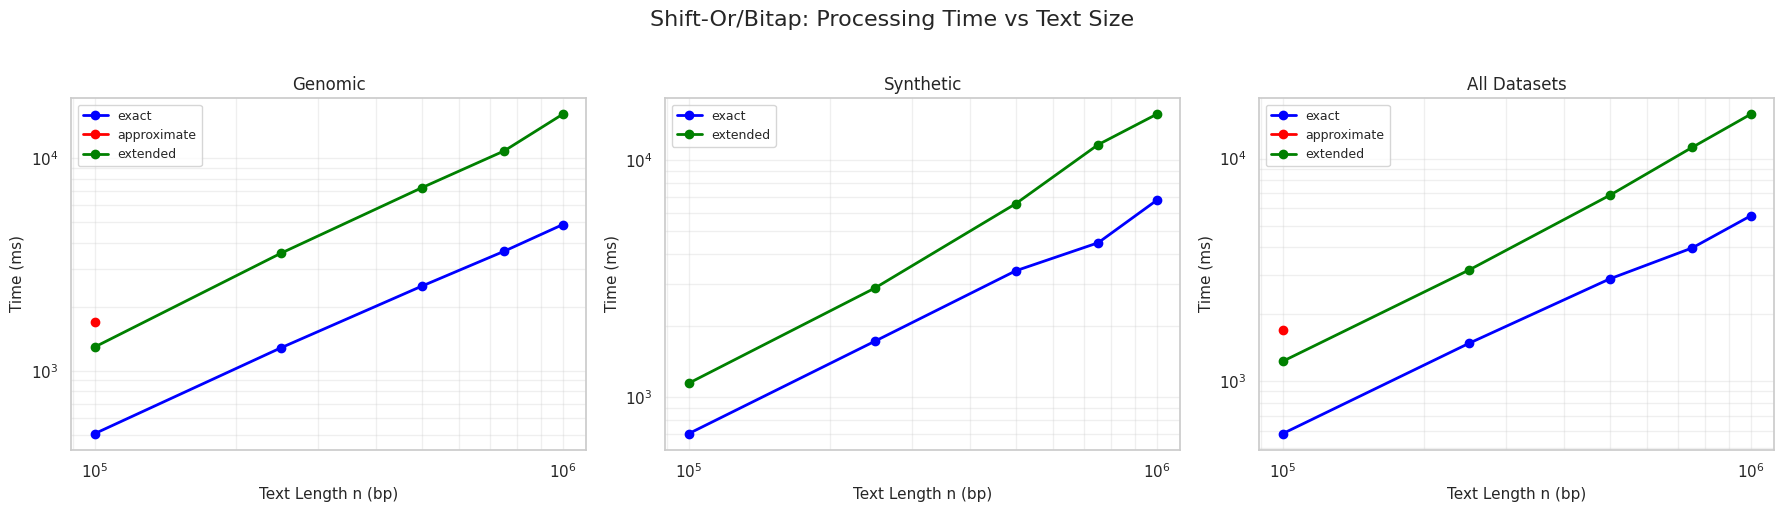

✓ Saved: analysis_graphs/graph1_time_vs_size.png


In [4]:
# Graph 1: Time vs Input Size (n)
print("Generating Graph 1: Time vs Input Size...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Shift-Or/Bitap: Processing Time vs Text Size', fontsize=16, y=1.02)

groups = ['genomic', 'synthetic', 'all']
colors = {'exact': 'blue', 'approximate': 'red', 'extended': 'green'}

for idx, group in enumerate(groups):
    ax = axes[idx]
    
    # Filter data
    if group == 'all':
        data = scaling_df
        title_suffix = 'All Datasets'
    else:
        data = scaling_df[scaling_df['dataset_group'] == group]
        title_suffix = group.title()
    
    # Plot each algorithm type
    for algo in data['algorithm_type'].unique():
        algo_data = data[data['algorithm_type'] == algo]
        
        # Group by text length and calculate mean
        grouped = algo_data.groupby('text_length_n').agg({
            'avg_time_s': ['mean', 'std']
        }).reset_index()
        
        x = grouped['text_length_n']
        y = grouped[('avg_time_s', 'mean')] * 1000  # Convert to ms
        
        ax.plot(x, y, 'o-', label=algo, color=colors.get(algo, 'gray'), 
                linewidth=2, markersize=6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Text Length n (bp)', fontsize=11)
    ax.set_ylabel('Time (ms)', fontsize=11)
    ax.set_title(title_suffix, fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/graph1_time_vs_size.png', bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/graph1_time_vs_size.png")

Generating Graph 2: Memory vs Input Size...



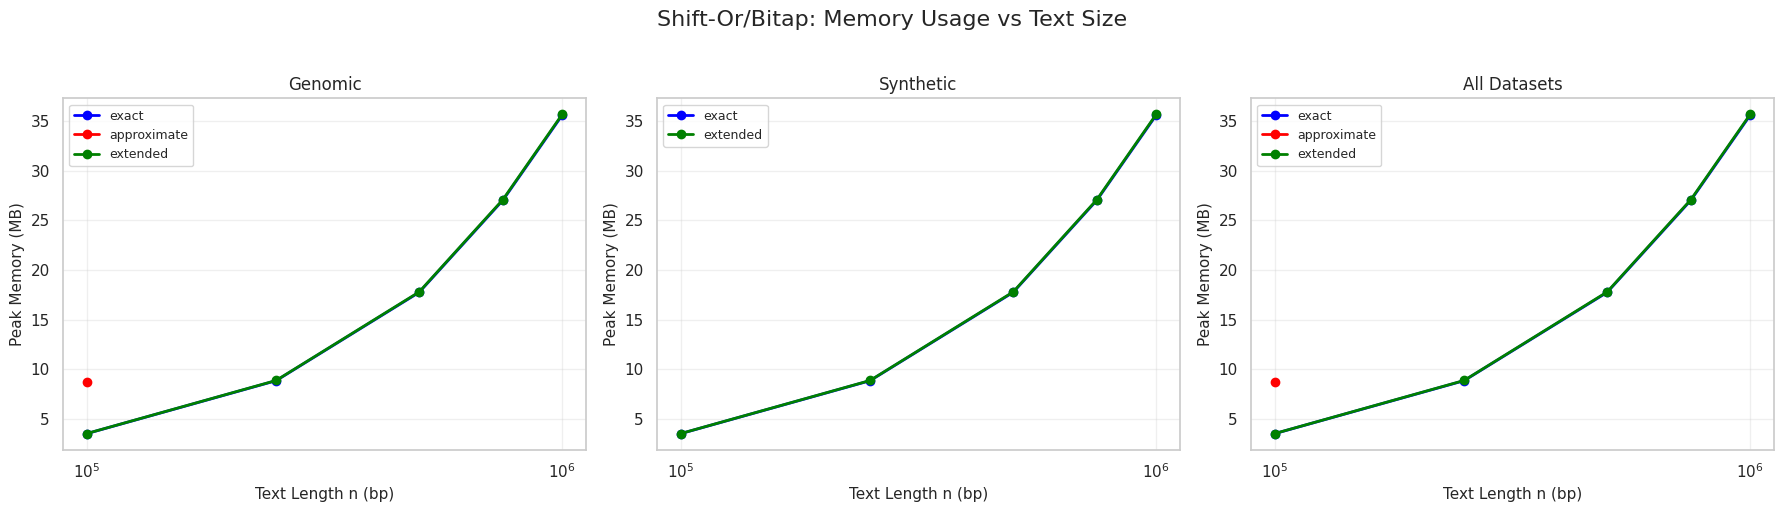

✓ Saved: analysis_graphs/graph2_memory_vs_size.png


In [5]:
# Graph 2: Memory Usage vs Input Size
print("Generating Graph 2: Memory vs Input Size...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Shift-Or/Bitap: Memory Usage vs Text Size', fontsize=16, y=1.02)

for idx, group in enumerate(groups):
    ax = axes[idx]
    
    if group == 'all':
        data = scaling_df
        title_suffix = 'All Datasets'
    else:
        data = scaling_df[scaling_df['dataset_group'] == group]
        title_suffix = group.title()
    
    for algo in data['algorithm_type'].unique():
        algo_data = data[data['algorithm_type'] == algo]
        
        grouped = algo_data.groupby('text_length_n')['peak_memory_mb'].mean()
        
        ax.plot(grouped.index, grouped.values, 'o-', label=algo, 
                color=colors.get(algo, 'gray'), linewidth=2, markersize=6)
    
    ax.set_xscale('log')
    ax.set_xlabel('Text Length n (bp)', fontsize=11)
    ax.set_ylabel('Peak Memory (MB)', fontsize=11)
    ax.set_title(title_suffix, fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/graph2_memory_vs_size.png', bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/graph2_memory_vs_size.png")

Generating Graph 3: Time vs Pattern Length...



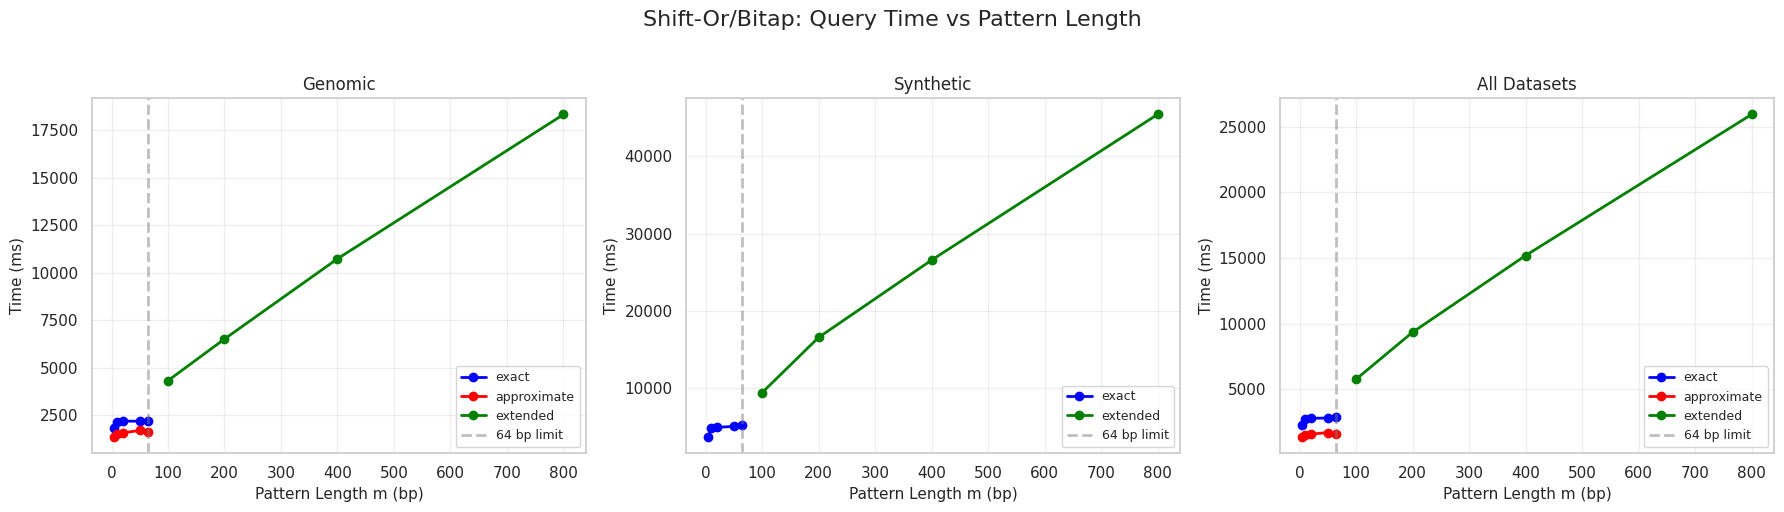

✓ Saved: analysis_graphs/graph3_time_vs_pattern.png


In [6]:
# Graph 3: Query Time vs Pattern Length (m)
print("Generating Graph 3: Time vs Pattern Length...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Shift-Or/Bitap: Query Time vs Pattern Length', fontsize=16, y=1.02)

for idx, group in enumerate(groups):
    ax = axes[idx]
    
    if group == 'all':
        data = pattern_df
        title_suffix = 'All Datasets'
    else:
        data = pattern_df[pattern_df['dataset_group'] == group]
        title_suffix = group.title()
    
    for algo in data['algorithm_type'].unique():
        algo_data = data[data['algorithm_type'] == algo]
        
        grouped = algo_data.groupby('pattern_length')['time_seconds_mean'].mean() * 1000
        
        ax.plot(grouped.index, grouped.values, 'o-', label=algo, 
                color=colors.get(algo, 'gray'), linewidth=2, markersize=6)
    
    # Add 64 bp boundary line
    ax.axvline(x=64, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='64 bp limit')
    
    ax.set_xlabel('Pattern Length m (bp)', fontsize=11)
    ax.set_ylabel('Time (ms)', fontsize=11)
    ax.set_title(title_suffix, fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/graph3_time_vs_pattern.png', bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/graph3_time_vs_pattern.png")

Generating Graph 4: Approximate Matching Analysis...



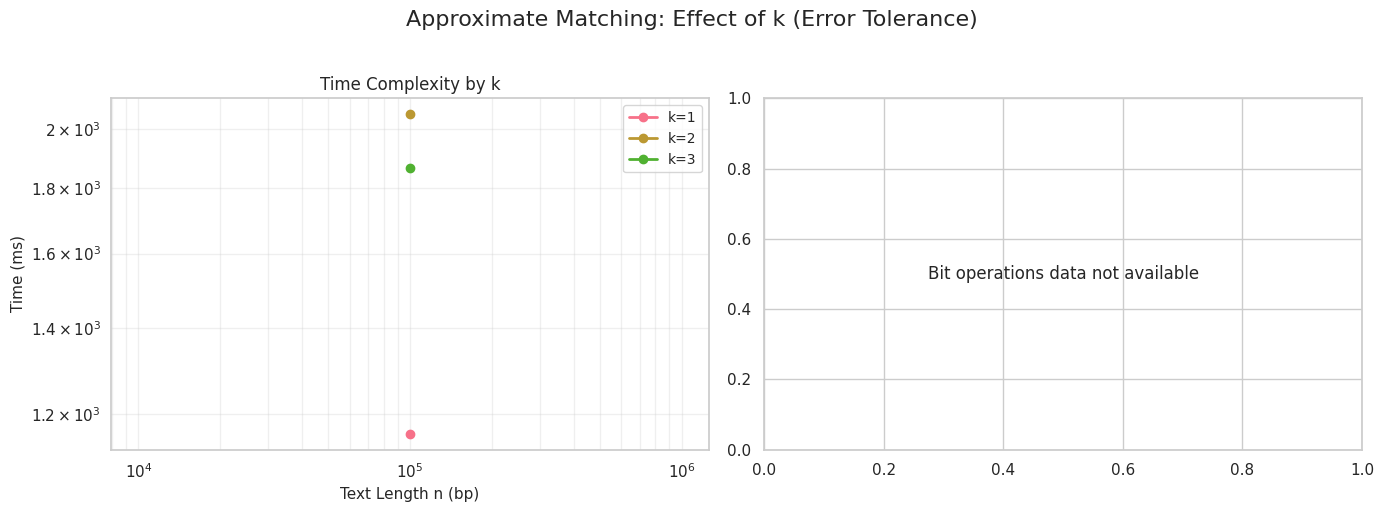

✓ Saved: analysis_graphs/graph4_approximate_k_effect.png


In [7]:
# Graph 4: Approximate Matching - Effect of k
print("Generating Graph 4: Approximate Matching Analysis...\n")

# Filter approximate matching data
approx_scaling = scaling_df[scaling_df['algorithm_type'] == 'approximate'].copy()
approx_pattern = pattern_df[pattern_df['algorithm_type'] == 'approximate'].copy()

if len(approx_scaling) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Approximate Matching: Effect of k (Error Tolerance)', fontsize=16, y=1.02)
    
    # Time vs k
    ax = axes[0]
    for k in sorted(approx_scaling['k_value'].unique()):
        k_data = approx_scaling[approx_scaling['k_value'] == k]
        grouped = k_data.groupby('text_length_n')['avg_time_s'].mean() * 1000
        ax.plot(grouped.index, grouped.values, 'o-', label=f'k={int(k)}', linewidth=2)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Text Length n (bp)', fontsize=11)
    ax.set_ylabel('Time (ms)', fontsize=11)
    ax.set_title('Time Complexity by k', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which='both')
    
    # Bit operations vs k (if available)
    ax = axes[1]
    if 'bit_operations' in approx_scaling.columns:
        for k in sorted(approx_scaling['k_value'].unique()):
            k_data = approx_scaling[approx_scaling['k_value'] == k]
            grouped = k_data.groupby('text_length_n')['bit_operations'].mean()
            ax.plot(grouped.index, grouped.values, 'o-', label=f'k={int(k)}', linewidth=2)
        
        ax.set_xscale('log')
        ax.set_xlabel('Text Length n (bp)', fontsize=11)
        ax.set_ylabel('Bit Operations', fontsize=11)
        ax.set_title('Bit Operations by k', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Bit operations data not available', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/graph4_approximate_k_effect.png', bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {OUTPUT_DIR}/graph4_approximate_k_effect.png")
else:
    print("⚠ No approximate matching data available")

In [8]:
# Summary Statistics
print("="*70)
print("SHIFT-OR/BITAP PERFORMANCE SUMMARY")
print("="*70)

# Dataset statistics
print("\n📊 Datasets Analyzed:")
print(f"  Total unique datasets: {scaling_df['dataset_name'].nunique()}")
print(f"  Genomic (GCA): {len(scaling_df[scaling_df['dataset_group']=='genomic']['dataset_name'].unique())}")
print(f"  Synthetic: {len(scaling_df[scaling_df['dataset_group']=='synthetic']['dataset_name'].unique())}")

# Algorithm performance
print("\n⚡ Algorithm Performance (Average):")
for algo in sorted(scaling_df['algorithm_type'].unique()):
    algo_data = scaling_df[scaling_df['algorithm_type'] == algo]
    avg_time = algo_data['avg_time_s'].mean() * 1000
    avg_mem = algo_data['peak_memory_mb'].mean()
    datasets = algo_data['dataset_name'].nunique()
    print(f"\n  {algo.title()}:")
    print(f"    Avg Time: {avg_time:.2f} ms")
    print(f"    Avg Memory: {avg_mem:.2f} MB")
    print(f"    Datasets: {datasets}")

# 64 bp boundary effect
if 'pattern_length' in pattern_df.columns:
    exact_df = pattern_df[pattern_df['algorithm_type'] == 'exact']
    extended_df = pattern_df[pattern_df['algorithm_type'] == 'extended']
    
    if len(exact_df) > 0 and len(extended_df) > 0:
        below_64 = exact_df[exact_df['pattern_length'] <= 64]['time_seconds_mean'].mean() * 1000
        above_64 = extended_df[extended_df['pattern_length'] > 64]['time_seconds_mean'].mean() * 1000
        
        print(f"\n📏 64 bp Boundary Effect:")
        print(f"  Patterns ≤64 bp (single-word): {below_64:.2f} ms")
        print(f"  Patterns >64 bp (multi-word): {above_64:.2f} ms")
        print(f"  Performance difference: {abs(above_64 - below_64):.2f} ms")
        print(f"  Overhead factor: {above_64/below_64:.2f}x")

# Approximate matching summary
if len(approx_scaling) > 0:
    print(f"\n🎯 Approximate Matching (k errors):")
    for k in sorted(approx_scaling['k_value'].unique()):
        k_data = approx_scaling[approx_scaling['k_value'] == k]
        avg_time = k_data['avg_time_s'].mean() * 1000
        print(f"  k={int(k)}: {avg_time:.2f} ms average")

# Data completeness
print(f"\n📈 Data Points:")
print(f"  Scaling measurements: {len(scaling_df)}")
print(f"  Pattern length measurements: {len(pattern_df)}")

print("\n" + "="*70)
print("✓ Analysis Complete!")
print(f"✓ Graphs saved to: {OUTPUT_DIR}/")
print("="*70)

SHIFT-OR/BITAP PERFORMANCE SUMMARY

📊 Datasets Analyzed:
  Total unique datasets: 30
  Genomic (GCA): 20
  Synthetic: 10

⚡ Algorithm Performance (Average):

  Approximate:
    Avg Time: 1691.96 ms
    Avg Memory: 8.74 MB
    Datasets: 5

  Exact:
    Avg Time: 2649.07 ms
    Avg Memory: 16.98 MB
    Datasets: 26

  Extended:
    Avg Time: 6588.43 ms
    Avg Memory: 16.16 MB
    Datasets: 23

📏 64 bp Boundary Effect:
  Patterns ≤64 bp (single-word): 2683.99 ms
  Patterns >64 bp (multi-word): 14049.88 ms
  Performance difference: 11365.89 ms
  Overhead factor: 5.23x

🎯 Approximate Matching (k errors):
  k=1: 1158.67 ms average
  k=2: 2053.61 ms average
  k=3: 1863.60 ms average

📈 Data Points:
  Scaling measurements: 192
  Pattern length measurements: 355

✓ Analysis Complete!
✓ Graphs saved to: analysis_graphs/
